# Graded Exercise Session: General Hough Transform

In this exercise we implement *General Hough Transform*. The objective is to use the algorithm to find the locations where the template ( ```template.png```) appears in the target image (```image.png```). The algorithm has 4 steps:
1. Computing the R-table (Q1.1, Q1.2)
2. Building the accumulator matrix (Q2)
3. Finding the object location (Q3) 
4. Extending the R-table to include the template in multiple scales(Q4)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.filters import sobel
from skimage.feature import canny
from skimage import io

# Load images
reference_I = io.imread("./images/template.png")
target_I = io.imread("./images/image.png")

centerPoint = (reference_I.shape[0] // 2, reference_I.shape[1] // 2)
r_table_row_count = 90

***Functions that might be useful except the ones that are specifically mentioned in the questions***
- ```np.sqrt()```: square root
- ```np.sin()```: sine
- ```np.cos()```: cosine
- ```int()``` : casts a float/double into an int

***To get built-in documentation of a function use the following:***

help(funtion_name)

ex: ```help(sobel)```

## Q1. Computing the R-table

Objective is to implement a function to compute the R-table.  As the name suggest, it is a table in which each row corresponds to an edge orientation ($\phi^m$). Each entry in the table represent an edge pixel location $(r^m_i,\alpha^m_i)$ with respect to a center point we select $(x_c,y_c)$. A single row in the table can have multiple such entries. When inserting a new entry $(r,\alpha)$ representing an edge pixel, we first find the orientation of that edge pixel. Then the orientation is used to find the row in the table and $(r,\alpha)$ is appended to the entries in that particular row. 

### Edge pixel representation in R-table $(r,\alpha)$ 
Let the center point we select be $(x_c,y_c)$ and edge pixel location be $(x,y)$, then
- $r^m_i = \sqrt{(x_c-x)^2+(y_c-y)^2}$
- $\alpha^m_i = {tan}^{-1}\big(\frac{y_c-y}{x_c-x}\big)$

<img src="references/r_table.png" alt="Drawing" style="width: 800px;" align=”left”/>

Note: The notation used in the slides of the above table and the image is slightly different. For clarity we have made some changes and we recommend you to use the above version.



### Q1.1 Edge orientation map 
First we need to find the edge orientation map. We use gradient direction at each edge pixel as the edge orientation.
For that, implement the function ```grad_directions``` that calculates the orientation of each pixel in the edge image. Edge image is already computed using the function ```canny```.

#### Input
- ```edge_image```: edge image

#### Output

- ```grad_directions```: Gradient direction map. It represents the edge orientations. Its dimensions are equal to the dimensions of ```image```. The value at pixel $(i,j)$ is the gradient direction at that point and it should be in the range $[0,2\pi]$

Note: 
- To compute gradient in x and y directions, you can use ```sobel``` filter function.
- You can use ```np.arctan2``` find the angle (the angle returned from ```arctan2``` is in the range $[-\pi,\pi]$).


In [2]:
def grad_directions(image):
    # -------------------------------
    # Implement your code here
    # -------------------------------
    grad_y = sobel(image, axis=0)
    grad_x = sobel(image, axis=1)
    
    grad_directions = np.arctan2(grad_y, grad_x) + np.pi
    # -------------------------------

    return grad_directions

Text(0.5, 1.0, 'Edge orientations')

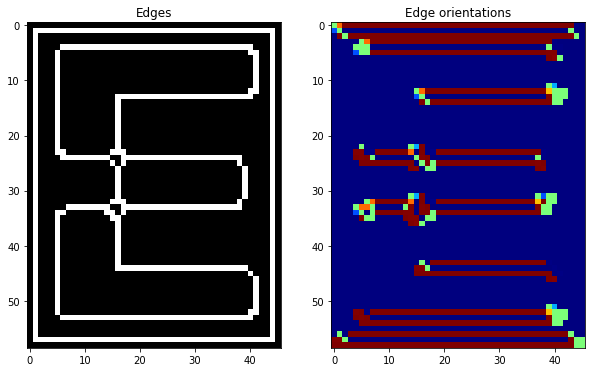

In [3]:
# -------------------------------
# Do not change this code 
# -------------------------------

# Visualizing the results
edges = canny(reference_I)
edge_orientations = grad_directions(edges)

fig = plt.figure(1, figsize=(10,15)) 
fig.add_subplot(1, 2, 1)
plt.imshow(edges,cmap='gray')
plt.title('Edges')

fig.add_subplot(1, 2, 2)
plt.imshow(np.float32(edge_orientations),cmap='jet')
plt.title('Edge orientations')
 
# -------------------------------

### Q1.2 Build the R-table
Implement the function ```build_r_table``` that computes the R-table given an template image, a center point and number of rows as arguments. In the function, R-table is implemented as a list of lists (```r_table = [[]] * row_count```). In it, the outer list corresponds to a row in the table and inner lists correspond to entries in a row. 


#### Input
- ```template```: template image
- ```center_point```: center point we select
- ```row_count```: number of rows in the r_table

#### Output
- ```r_table```: R-table

Note: 
- Orientation values can be in the range $[0,2\pi]$. Since we need a finite number of rows in the R-table, we discretize the range into ```r_table_row_count``` number of bins.


In [4]:
def build_r_table(template, center_point, row_count):
    edges = canny(template)
    orientations = grad_directions(edges) 
    r_table = [[] for i in range(row_count)] 
 
    # -------------------------------
    # Implement your code here
    # -------------------------------
    for (x, y), value in np.ndenumerate(edges):
        if value:
            r = np.sqrt((center_point[0] - x) ** 2 + (center_point[1] - y) ** 2)
            a = np.arctan2(center_point[1] - y, center_point[0] - x) + np.pi
            
            row_idx = int(row_count * orientations[x, y] / (2 * np.pi))
            r_table[row_idx].append((r, a))
    
    # -------------------------------
    return r_table

In [5]:
# -------------------------------
# Do not change this code 
# -------------------------------
centerPoint = (reference_I.shape[0] // 2, reference_I.shape[1] // 2)
r_table_row_count = 90

r_table = build_r_table(reference_I, centerPoint, r_table_row_count) 
# -------------------------------

## Q2. Build the accumulator matrix
Implement the function ```compute_accumulator_array``` that computes the accumulator array given an input image and a R-table.

#### Input
- ```target_I```: input image
- ```r_table```: r_table of the template

#### Output

- ```accumulator```: the accumulator array that keeps the votes

Note: Accumulator array has dimensions equal to the input image and in it we vote for ***candidate center points***. Please refer to page number 73 in slides Delineation.pdf (we have also included the slide 73 in the 'references' directory)

In [6]:
def compute_accumulator_array(target_I, r_table):
    edges = canny(target_I) 
    orientations = grad_directions(edges) 
    # -------------------------------
    # Implement your code here
    # -------------------------------
    accumulator = np.zeros(target_I.shape)
    
    for (x, y), value in np.ndenumerate(edges):
        if value:
            row_idx = int(len(r_table) * orientations[x, y] / (2 * np.pi))
            for (r, a) in r_table[row_idx]:
                accumulator_x = int(x + r * np.sin(a))
                accumulator_y = int(y + r * np.cos(a))
                
                if accumulator_x < accumulator.shape[0] and accumulator_y < accumulator.shape[1] and accumulator_x > 0 and accumulator_y > 0:
                    accumulator[accumulator_x, accumulator_y] += 1
    # -------------------------------
    return accumulator



Text(0.5, 1.0, 'Accumulator')

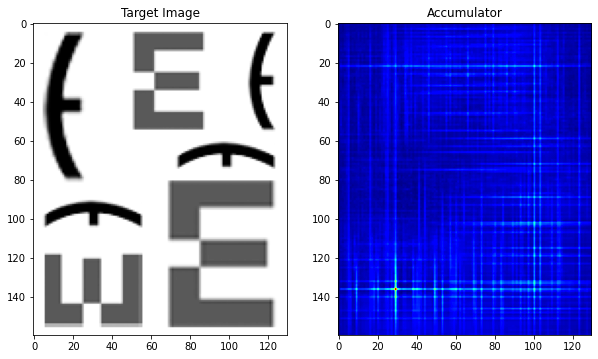

In [7]:
# -------------------------------
# Do not change this code 
# -------------------------------
accumulator_array = compute_accumulator_array(target_I, r_table) 

fig = plt.figure(figsize=(10,15))

fig = plt.figure(1, figsize=(10,15)) 
fig.add_subplot(1, 2, 1)
plt.imshow(target_I,cmap='gray') 
plt.title('Target Image')

fig.add_subplot(1, 2, 2)
plt.imshow(accumulator_array,cmap='jet')
plt.title('Accumulator') 
# -------------------------------

## Q3. Return top-k results
Implement a function ```max_votes``` that returns the point coordinates corresponding to top-k elements that have the maximum votes.
#### Input

- ```accumulator_array```: accumulator array
- ```top_k```: number of points to return

#### Output

- ```top_k_points```: the coordinates of the points that have the maximum votes. It can be a list of tuples with each tuple being (y,x) coordinates.

In [8]:
def max_votes(accumulator_array, top_k):
    # -------------------------------
    # Implement your code here
    # -------------------------------
    top_idx = accumulator_array.ravel().argsort()[-top_k:]
    top_k_points = list((np.unravel_index(i, accumulator_array.shape)) for i in top_idx)
    
    # -------------------------------
    return top_k_points

In [9]:
# -------------------------------
# Do not change this code 
# -------------------------------
def visualize(figure_id, reference_I, target_I, accumulator, object_locations):
    fig = plt.figure(figure_id, figsize=(10,15))
    plt.gray()

    fig.add_subplot(2, 2, 1)
    plt.title('Reference image')
    plt.imshow(reference_I)

    fig.add_subplot(2, 2, 2)
    plt.title('Target image')
    plt.imshow(target_I)

    fig.add_subplot(2, 2, 3)
    plt.title('Accumulator')
    plt.imshow(accumulator, cmap='jet')

    fig.add_subplot(2, 2, 4)
    plt.title('Detection')
    plt.imshow(target_I)

    # top 5 results in red

    y_points = [pt[0] for pt in object_locations]
    x_points = [pt[1] for pt in object_locations]
    plt.scatter(x_points, y_points, marker='o', color='r')

    plt.show()
# -------------------------------


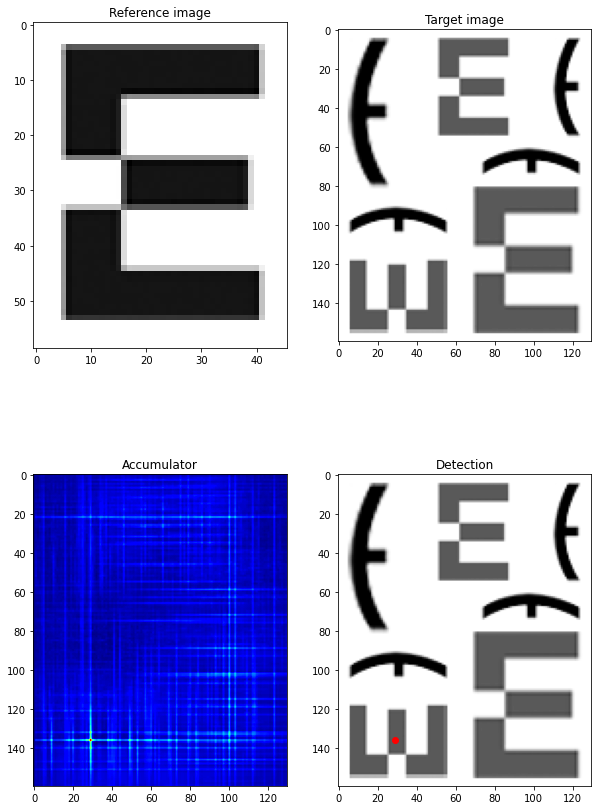

In [10]:
# -------------------------------
# Do not change this code 
# -------------------------------
object_locations = max_votes(accumulator_array, 1)
visualize(1, reference_I, target_I, accumulator_array, object_locations)
# -------------------------------


## Q4. Extending R-table to include different scales of the object

So far, the algorithm can only detect the template if it appears exactly in the same scale in the target image. To enable detecting the template object in multiple scales, implement the function ```build_r_table_multi_scale```.
 

#### Input
- ```r_table```: R-table from Q1 
- ```scales```: list of scales

#### Output
- ```r_table_extended```: extended R-table. It should contain entries corresponding to template at all the scales specified in ```scales```.

Note: 
- For an entry $(r,\alpha)$, you need to computed the scaled version. Think about which values in $(r,\alpha)$ changes when you scale the template. 

In [11]:
def build_r_table_multi_scale(r_table, scales):
    
    row_count = len(r_table)
    r_table_extended = [[] for i in range(row_count)]
    
    # -------------------------------
    # Implement your code here
    # -------------------------------
    for s in scales:
        for phi_idx, row in enumerate(r_table):
            for (r, a) in row:
                r_table_extended[phi_idx].append((s*r, a))
    
    # -------------------------------
    return r_table_extended

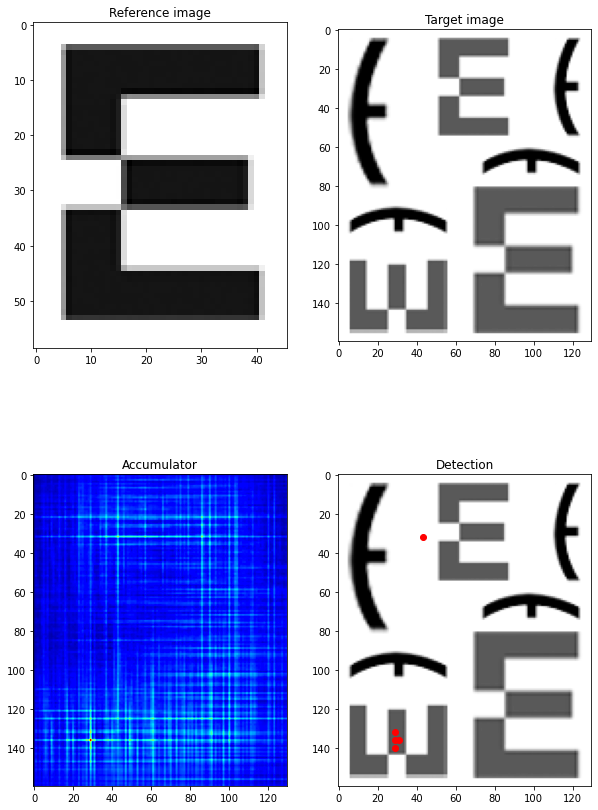

In [12]:
# -------------------------------
# Do not change this code 
# ------------------------------- 
scales = [1,1.5]
r_table_extended = build_r_table_multi_scale(r_table, scales)

accumulator = compute_accumulator_array(target_I, r_table_extended)
object_locations = max_votes(accumulator, 5)
visualize(3, reference_I, target_I, accumulator, object_locations)
# -------------------------------